# Self supervised Learning

Pretrain a "foundation model" using data without outcomes, from a large unlabeled dataset. Note that the idea behind the pre-training is to guide the fine tunning task (survival prediction). **Note that given this is a toy example the pre-training effect may be marginal.** 

The input to the mode are the features from the dataset and **not the outcomes**

**Note that this notebook may take a while to complete when number of epochs is large**: For self supervised learning it is recommended to use a large  number of epochs. For illustration, we ran it for 1,000 epochs. 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/shenwanxiang/anaconda3"
import tensorflow as tf
tf.test.is_gpu_available()
tf.__version__

2025-08-14 18:32:27.862203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 18:32:27.918603: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 18:32:28.264868: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenwanxiang/anaconda3/lib:
2025-08-14 18:32:28.264902: W tensorflow/compiler/xla/stream_exe

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2025-08-14 18:32:28.665750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 18:32:28.675950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 18:32:28.691712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 18:32:28.691799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

'2.11.0'

In [2]:
import sys
sys.path.append('../../codeocean/environment/clinical_transformer/')

import pandas as pd
from collections import Counter

from xai.models.SimplifiedClinicalTransformer.Trainer import Trainer
from xai.losses.survival import cIndex_SigmoidApprox as cindex_loss
from xai.metrics.survival import sigmoid_concordance as cindex

from xai.models import Trainer
from xai.models import SelfSupervisedTransformer
from xai.models import OptimizedSelfSupervisedDataGenerator as SelfSupervisedDataGenerator

from xai.losses.selfsupervision.classifier_regression import CompositeLoss

In [3]:
from samecode.random import set_seed

## Parameters

In [4]:
max_features_percentile=100
test_size=0.1
mode='self-supervision'
learning_rate=0.0001
repetitions=1
epochs=2000
verbose=2
seed=0
embedding_size = 128
num_heads = 2
num_layers = 8

loss = CompositeLoss(feature_w=1, value_w=0.1) # Contribution of individual losses (predicts keys, values) 

In [5]:
data = pd.read_csv('./data/dataset-pretrain.data.csv')
features = data.columns[-43:].tolist()
#features


In [6]:
!rm -r ./FoundationModel

/bin/sh: /home/shenwanxiang/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/sh)


In [7]:
set_seed(0)
outdir = './FoundationModel/'

trainer = Trainer(
    out_dir = outdir,
    max_features_percentile=max_features_percentile,
    test_size=test_size,
    mode=mode,
    model=SelfSupervisedTransformer, 
    dataloader=SelfSupervisedDataGenerator,
    loss=loss,
    metrics=[]
)

trainer.setup_data(
    data, 
    discrete_features = [],
    continuous_features = features,
)

trainer.setup_model(
    embedding_size=embedding_size, 
    num_heads=num_heads, 
    num_layers=num_layers,
    learning_rate=learning_rate,
    batch_size_max = False,
    batch_size=4000, # This will take a batch with the size of the training / testing shape,
    save_best_only=False
)

trainer.fit(repetitions=repetitions, epochs=epochs, verbose=verbose, seed=seed)

/home/shenwanxiang/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO	2025-08-14 18:32:30,131	Setting up working directory: ./FoundationModel/
INFO	2025-08-14 18:32:30,133	Number of continuous features: 43
INFO	2025-08-14 18:32:30,133	Number of discrete features: 0
INFO	2025-08-14 18:32:30,134	Number of samples: 10184
INFO	2025-08-14 18:32:30,147	Number of classes: 51
INFO	2025-08-14 18:32:30,147	RUN ID: fold-0_id-0
INFO	2025-08-14 18:32:30,148	RUN ID out directory: ./FoundationModel//fold-0_id-0/
INFO	2025-08-14 18:32:31,027	Training samples: 9165
INFO	2025-08-14 18:32:31,028	Testing samples: 1019
INFO	2025-08-14 18:32:31,050	Number of features at 100th percentile: 43 that are non nans
2025-08-14 18:32:31.051303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successfu

Epoch 1/2000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:31,911	AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f81cc10db90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:31,916	AutoGraph could not transform <bound method SelfSupervisedTransformer.call of <xai.models.SimplifiedClinicalTransformer.Topologies.BertLikeTransformer.BertLikeAttention.SelfSupervisedTransformer object at 0x7f82f0166310>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:31,924	AutoGraph could not transform <bound method Encoder.call of <xai.models.SimplifiedClinicalTransformer.utils.Encoder object at 0x7f82f0166f50>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:31,929	AutoGraph could not transform <bound method NumericalEmbeddingLayer.call of <xai.models.SimplifiedClinicalTransformer.utils.NumericalEmbeddingLayer object at 0x7f82f0166a50>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:31,938	AutoGraph could not transform <bound method TokenEmbeddingLayer.call of <xai.models.SimplifiedClinicalTransformer.utils.TokenEmbeddingLayer object at 0x7f82f0174c90>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:31,946	AutoGraph could not transform <bound method EncoderLayer.call of <xai.models.SimplifiedClinicalTransformer.utils.EncoderLayer object at 0x7f82f0180c10>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:31,950	AutoGraph could not transform <bound method MultiHeadAttention.call of <xai.models.SimplifiedClinicalTransformer.utils.MultiHeadAttention object at 0x7f82f010d910>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:32,536	AutoGraph could not transform <bound method CompositeLoss.call of <xai.losses.selfsupervision.classifier_regression.CompositeLoss object at 0x7f82fe75b410>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:33,152	AutoGraph could not transform <bound method _BaseOptimizer._update_step_xla of <tensorflow.python.eager.polymorphic_function.tracing_compiler.TfMethodTarget object at 0x7f81405f3350>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-08-14 18:32:37.488608: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0xb34f7ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 18:32:37.488634: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-08-14 18:32:37.492387: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-14 18:32:37.529765: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-14 18:32:37.548900: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 18:32:42,621	AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f810c4b4dd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 - 11s - loss: 0.9849 - val_loss: 0.8910 - 11s/epoch - 6s/step
Epoch 2/2000
2/2 - 1s - loss: 0.9272 - val_loss: 0.8539 - 763ms/epoch - 381ms/step
Epoch 3/2000
2/2 - 1s - loss: 0.8970 - val_loss: 0.8561 - 747ms/epoch - 374ms/step
Epoch 4/2000
2/2 - 1s - loss: 0.8833 - val_loss: 0.8501 - 765ms/epoch - 383ms/step
Epoch 5/2000
2/2 - 1s - loss: 0.8743 - val_loss: 0.8318 - 760ms/epoch - 380ms/step
Epoch 6/2000
2/2 - 1s - loss: 0.8651 - val_loss: 0.8175 - 749ms/epoch - 374ms/step
Epoch 7/2000
2/2 - 1s - loss: 0.8573 - val_loss: 0.8072 - 761ms/epoch - 380ms/step
Epoch 8/2000
2/2 - 1s - loss: 0.8503 - val_loss: 0.7974 - 763ms/epoch - 382ms/step
Epoch 9/2000
2/2 - 1s - loss: 0.8438 - val

In [10]:
from xai.models import clean_run
clean_run(
    path='./FoundationModel/',
    keep=[1, 10, 100, 500, 1000,1500,2000]
)

Processing: ./FoundationModel/


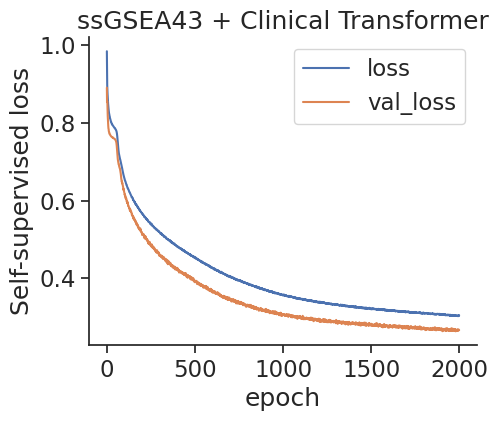

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)
dfh = pd.read_csv("./FoundationModel/fold-0_id-0/history.csv", index_col=0)
fig, ax = plt.subplots(figsize=(5, 4))
dfh.plot(ax=ax)
ax.tick_params(bottom=True, left=True)
ax.set_ylabel('Self-supervised loss')
ax.set_title('ssGSEA43 + Clinical Transformer')
sns.despine()
fig.savefig('./FoundationModel/fold-0_id-0/history.svg', bbox_inches = 'tight')